In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter

plt.ion()   # interactive mode
%matplotlib inline

Load Data
---------


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images


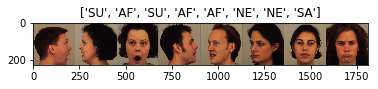

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [4]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, writer=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [8]:
model_ft = models.densenet161(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

writer = SummaryWriter('./logs/densenet161_full')

C:\Users\bikas\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


### Train and evaluate



In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=20)

Epoch 0/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:11<00:00,  3.04it/s]


train Loss: 1.0776 Acc: 0.5870


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.10it/s]


val Loss: 0.4433 Acc: 0.8138

Epoch 1/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:14<00:00,  2.98it/s]


train Loss: 0.4293 Acc: 0.8512


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.07it/s]


val Loss: 0.2593 Acc: 0.8907

Epoch 2/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.2897 Acc: 0.9056


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.09it/s]


val Loss: 0.2000 Acc: 0.9190

Epoch 3/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.1824 Acc: 0.9439


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.94it/s]


val Loss: 0.1526 Acc: 0.9555

Epoch 4/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.97it/s]


train Loss: 0.1436 Acc: 0.9551


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.11it/s]


val Loss: 0.1588 Acc: 0.9474

Epoch 5/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.0832 Acc: 0.9781


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.07it/s]


val Loss: 0.1204 Acc: 0.9555

Epoch 6/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.97it/s]


train Loss: 0.0509 Acc: 0.9862


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.06it/s]


val Loss: 0.1003 Acc: 0.9595

Epoch 7/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.0458 Acc: 0.9884


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.10it/s]


val Loss: 0.0891 Acc: 0.9717

Epoch 8/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.97it/s]


train Loss: 0.0389 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.15it/s]


val Loss: 0.0778 Acc: 0.9798

Epoch 9/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.97it/s]


train Loss: 0.0408 Acc: 0.9899


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.03it/s]


val Loss: 0.0768 Acc: 0.9879

Epoch 10/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.97it/s]


train Loss: 0.0365 Acc: 0.9908


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.07it/s]


val Loss: 0.0798 Acc: 0.9757

Epoch 11/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.0320 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.04it/s]


val Loss: 0.0783 Acc: 0.9798

Epoch 12/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.0285 Acc: 0.9940


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.10it/s]


val Loss: 0.0767 Acc: 0.9757

Epoch 13/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.0304 Acc: 0.9933


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.10it/s]


val Loss: 0.0829 Acc: 0.9757

Epoch 14/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.0307 Acc: 0.9942


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.02it/s]


val Loss: 0.0828 Acc: 0.9717

Epoch 15/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.0286 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.15it/s]


val Loss: 0.0688 Acc: 0.9798

Epoch 16/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.97it/s]


train Loss: 0.0316 Acc: 0.9938


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.09it/s]


val Loss: 0.0835 Acc: 0.9717

Epoch 17/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.96it/s]


train Loss: 0.0311 Acc: 0.9942


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.01it/s]


val Loss: 0.0814 Acc: 0.9798

Epoch 18/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.0279 Acc: 0.9942


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.06it/s]


val Loss: 0.0713 Acc: 0.9879

Epoch 19/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.97it/s]


train Loss: 0.0279 Acc: 0.9942


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.04it/s]


val Loss: 0.0891 Acc: 0.9676

Epoch 20/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.0329 Acc: 0.9920


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.10it/s]


val Loss: 0.0792 Acc: 0.9717

Epoch 21/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.97it/s]


train Loss: 0.0295 Acc: 0.9940


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.98it/s]


val Loss: 0.0813 Acc: 0.9757

Epoch 22/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:13<00:00,  3.00it/s]


train Loss: 0.0304 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.11it/s]


val Loss: 0.0765 Acc: 0.9798

Epoch 23/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.98it/s]


train Loss: 0.0284 Acc: 0.9951


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.05it/s]


val Loss: 0.0727 Acc: 0.9798

Epoch 24/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.97it/s]


train Loss: 0.0287 Acc: 0.9929


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.99it/s]


val Loss: 0.0750 Acc: 0.9798

Epoch 25/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.97it/s]


train Loss: 0.0291 Acc: 0.9933


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.13it/s]


val Loss: 0.0764 Acc: 0.9717

Epoch 26/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.96it/s]


train Loss: 0.0309 Acc: 0.9931


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.09it/s]


val Loss: 0.0786 Acc: 0.9717

Epoch 27/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.96it/s]


train Loss: 0.0266 Acc: 0.9951


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.09it/s]


val Loss: 0.0704 Acc: 0.9757

Epoch 28/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:15<00:00,  2.97it/s]


train Loss: 0.0240 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.98it/s]


val Loss: 0.0749 Acc: 0.9717

Epoch 29/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.97it/s]


train Loss: 0.0318 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.01it/s]


val Loss: 0.0715 Acc: 0.9838

Epoch 30/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:17<00:00,  2.95it/s]


train Loss: 0.0272 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.08it/s]


val Loss: 0.0754 Acc: 0.9757

Epoch 31/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.96it/s]


train Loss: 0.0264 Acc: 0.9951


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.05it/s]


val Loss: 0.0805 Acc: 0.9757

Epoch 32/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.96it/s]


train Loss: 0.0310 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.05it/s]


val Loss: 0.0937 Acc: 0.9676

Epoch 33/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.97it/s]


train Loss: 0.0297 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.97it/s]


val Loss: 0.0849 Acc: 0.9757

Epoch 34/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:16<00:00,  2.96it/s]


train Loss: 0.0260 Acc: 0.9944


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.10it/s]


val Loss: 0.0692 Acc: 0.9838

Training complete in 117m 12s
Best val Acc: 0.987854
